# Strabismus Journal - Fine Tuning based Binary Classification(EfficientNet)

### Import

In [1]:
# system library
import os, shutil, sys

# Custom module import
sys.path.append('/mnt/temp/Stra_Paper/module')
from directory_module import dir_check_master, copy_jpg_files, path_make, directory_definder
from custom_dataset import prepare_dataset, src_data_namer
from custom_results import custom_confusion_matrix, model_saver, save_metrics, open_pkl
from custom_models import custom_models
from learning import training, evaluation
from flag_module import augmentation_check
from custom_tools import calculation_time

# related to pytorch basic module
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, SubsetRandomSampler

# for model
from efficientnet_pytorch import EfficientNet
import torchvision.models as models

from torch_optimizer import RAdam, AdamP

# third-party applications
import wandb

# Additional python library
import time
import random

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, roc_auc_score
from scipy import stats
import pickle

# for configuration
from omegaconf import OmegaConf, DictConfig

### Helper

In [2]:
def __main__(lab_name, model_name, device, num_classes, checkpoints_model_dir, learning_rate, train_loader, valid_loader, test_loader):
    
    # Model Define
    init_model = custom_models(model_name, device, num_classes)
    model, optimizer, scheduler, criterion = init_model.learning_definder(learning_rate)
    
    # Learning Loop
    learning_init = training(model, optimizer, scheduler, criterion, num_epochs)
    eval_model, overfitting_value = learning_init.learning_loop(train_loader, valid_loader, device)

    # Model Save
    model_saver.model_save(eval_model, overfitting_value, lab_name, model_name, checkpoints_model_dir, option_name = '')

    # Evaluation
    evaluation.evaluation_loop(eval_model, device, lab_name, model_name, classes, option_name, test_loader, checkpoints_results_dir)
    
def __directory__(base_dir, lab_name, classes, dir_print_option, aug_data_flag):
    
    # Directory Setting
    
    init_dir_base = directory_definder(lab_name, base_dir, classes, dir_print_option = dir_print_option, aug_data_flag = aug_data_flag)

    data_base_dir, lab_data_dir, lab_train_dir, lab_train_normal_dir, lab_train_stra_dir, lab_test_dir, lab_test_normal_dir, lab_test_stra_dir = init_dir_base.lab_dir_maker()

    checkpoints_model_dir, checkpoints_dataset_pkl_dir, checkpoints_learning_history_dir, checkpoints_results_dir = init_dir_base.checkpoints_dir_maker()

    if aug_data_flag:
        src_train_normal_dir, src_train_stra_dir, src_train_normal_aug_dir, src_train_stra_aug_dir, src_test_normal_dir, src_test_stra_dir = init_dir_base.dataset_dir_maker()
        return data_base_dir, lab_data_dir, lab_train_dir, lab_train_normal_dir, lab_train_stra_dir, lab_test_dir, lab_test_normal_dir, lab_test_stra_dir, checkpoints_model_dir, checkpoints_dataset_pkl_dir, checkpoints_learning_history_dir, checkpoints_results_dir, src_train_normal_dir, src_train_stra_dir, src_train_normal_aug_dir, src_train_stra_aug_dir, src_test_normal_dir, src_test_stra_dir 
    else:
        src_train_normal_dir, src_train_stra_dir, src_test_normal_dir, src_test_stra_dir = init_dir_base.dataset_dir_maker()
        return data_base_dir, lab_data_dir, lab_train_dir, lab_train_normal_dir, lab_train_stra_dir, lab_test_dir, lab_test_normal_dir, lab_test_stra_dir, checkpoints_model_dir, checkpoints_dataset_pkl_dir, checkpoints_learning_history_dir, checkpoints_results_dir, src_train_normal_dir, src_train_stra_dir, src_test_normal_dir, src_test_stra_dir 
        
def __hyperparameters__(l_group, l_num):
    # System parameters
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_workers = 16
    
    # for Dataset
    random_seed = 42
    train_val_ratio = 0.8
    
    # Lab Setting
    lab_group = l_group
    lab_num = str(int(l_num))
    lab_name = lab_group + '_' + lab_num
    
    # for Learning
    classes = ['normal', 'stra']
    
    init_aug_checker = augmentation_check(lab_group, lab_num)
    aug_data_flag = init_aug_checker.aug_data_flag()
    
    model_list = [
        #'efficientnet-b0',
        #'efficientnet-b1',
        #'resnet18',
        #'resnet34',
        'resnet50',
        #'resnet101',
        #'resnet152',
        #'resnext50_32x4d',
        'resnext101_32x8d'
        #'wide_resnet50_2',
        #'wide_resnet101_2'
    ]
    
    num_epochs = 50
    learning_rate = 1e-4
    num_classes = len(classes)
    batch_size = 32
    
    # Flag
    option_name = '_' + 'batch32'
    #option_name = ''
    
    dir_print_option = False # Directory print option
    
    print(f"device : {device}")
    print(f"num_workers : {num_workers}")
    print(f"random_seed : {random_seed}")
    print(f"lab_name : {lab_name}")
    print(f"classes : {classes}")
    print(f"model_list : {model_list}")
    print(f"num_epochs : {num_epochs}")
    print(f"learning_rate : {learning_rate}")
    print(f"batch_size : {batch_size}")
    print(f"aug_data_flag : {aug_data_flag}")
    print(f"dir_print_option : {dir_print_option}")
    print(f"option_name : {option_name}")
    
    return device, num_workers, random_seed, lab_name, classes, model_list, num_epochs, learning_rate, num_classes, batch_size, aug_data_flag, dir_print_option, option_name, train_val_ratio
    
def __prepare_dataset__(src_train_normal_dir, src_train_stra_dir, src_test_normal_dir, src_test_stra_dir, lab_train_normal_dir, lab_train_stra_dir, lab_test_normal_dir, lab_test_stra_dir):
    # data preperation check

    prepare_dataset.custom_dataset_prepare(src_train_normal_dir, lab_train_normal_dir)
    prepare_dataset.custom_dataset_prepare(src_train_stra_dir, lab_train_stra_dir)
    prepare_dataset.custom_dataset_prepare(src_test_normal_dir, lab_test_normal_dir)
    prepare_dataset.custom_dataset_prepare(src_test_stra_dir, lab_test_stra_dir)

    print('train normal : ', len(os.listdir(lab_train_normal_dir)))
    print('train stra : ', len(os.listdir(lab_train_stra_dir)))
    print('test normal : ', len(os.listdir(lab_test_normal_dir)))
    print('test stra : ', len(os.listdir(lab_test_stra_dir)))
    
def __aug_prepare_dataset__(src_train_normal_dir, src_train_stra_dir, src_test_normal_dir, src_test_stra_dir, lab_train_normal_dir, lab_train_stra_dir, src_train_normal_aug_dir, src_train_stra_aug_dir, lab_test_normal_dir, lab_test_stra_dir):
    # data preperation check

    prepare_dataset.custom_dataset_prepare(src_train_normal_dir, lab_train_normal_dir)
    prepare_dataset.custom_dataset_prepare(src_train_stra_dir, lab_train_stra_dir)
    prepare_dataset.custom_dataset_prepare(src_test_normal_dir, lab_test_normal_dir)
    prepare_dataset.custom_dataset_prepare(src_test_stra_dir, lab_test_stra_dir)
    
    prepare_dataset.custom_dataset_prepare(src_train_normal_aug_dir, lab_train_normal_dir)
    prepare_dataset.custom_dataset_prepare(src_train_stra_aug_dir, lab_train_stra_dir)

    print('train normal : ', len(os.listdir(lab_train_normal_dir)))
    print('train stra : ', len(os.listdir(lab_train_stra_dir)))
    print('test normal : ', len(os.listdir(lab_test_normal_dir)))
    print('test stra : ', len(os.listdir(lab_test_stra_dir)))
    
def __Dataset_Make_Loading__(random_seed, lab_train_dir, lab_test_dir, batch_size, num_workers, train_val_ratio):
    from sklearn.model_selection import train_test_split
    torch.manual_seed(random_seed)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation((-5, 5)),
        #transforms.ColorJitter(brightness=.5, hue = .05, contrast = .2),
        #transforms.GaussianBlur(kernel_size=(1,1)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    valid_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    train_dataset = torchvision.datasets.ImageFolder(root=lab_train_dir, transform=transform)
    valid_dataset = torchvision.datasets.ImageFolder(root=lab_train_dir, transform=valid_transform)
    test_dataset = torchvision.datasets.ImageFolder(root=lab_test_dir, transform=test_transform)


    # train 데이터셋에서 80% 비율로 학습용 데이터셋, 나머지 비율로 검증용 데이터셋 생성
    train_size = len(train_dataset)
    indices = list(range(train_size))
    #split = int(train_size * train_val_ratio)
    #train_indices, valid_indices = train_indices[:split], train_indices[split:]
    train_indices, valid_indices = train_test_split(indices, test_size = (1-train_val_ratio), random_state = random_seed)

    # SubsetRandomSampler를 사용하여 train 데이터셋과 validation 데이터셋에 대한 인덱스를 나눠줍니다.
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(valid_indices)

    # 데이터 로더 설정
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)
    
    print(f"The number of Train data : {len(train_loader)*32}")
    print(f"The number of Validation data : {len(valid_loader)*32}")
    print(f"The number of Test data : {len(test_loader)*32}")
    
    return train_loader, valid_loader, test_loader

### Hyperparameter, Directorys, Dataset, Learning and Evaluation

device : cuda:0
num_workers : 16
random_seed : 42
lab_name : G3_5
classes : ['normal', 'stra']
model_list : ['resnet50', 'resnext101_32x8d']
num_epochs : 50
learning_rate : 0.0001
batch_size : 32
aug_data_flag : True
dir_print_option : False
option_name : _batch32

aug mode
train normal :  2800
train stra :  2800
test normal :  96
test stra :  100

The number of Train data : 4480
The number of Validation data : 1120
The number of Test data : 224

resnet50 learinng start ! 


model learning start

Epoch [1/50], Train Loss: 0.3809, Valid Loss: 0.0577, Train Acc: 0.7473, Valid Acc: 0.8643,     overfitting checker: Loss : -0.3232, Acc : 0.1170
Epoch [2/50], Train Loss: 0.1892, Valid Loss: 0.0339, Train Acc: 0.8871, Valid Acc: 0.9170,     overfitting checker: Loss : -0.1553, Acc : 0.0299
Epoch [3/50], Train Loss: 0.1444, Valid Loss: 0.0308, Train Acc: 0.9129, Valid Acc: 0.9295,     overfitting checker: Loss : -0.1136, Acc : 0.0165
Epoch [4/50], Train Loss: 0.1244, Valid Loss: 0.0307, Train 

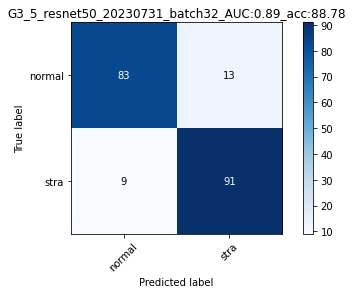

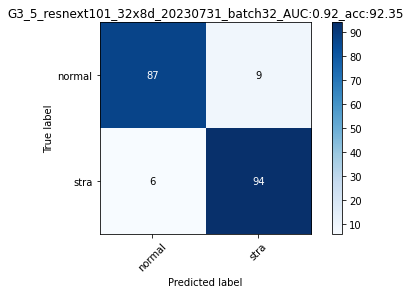

In [3]:
start_lab_num = 5
end_lab_num = 5

lab_iter = range(start_lab_num, end_lab_num + 1)

for iter_val in lab_iter:
    # Hyper-parameters Setting

    lab_group = 'G3'
    lab_num = iter_val
    device, num_workers, random_seed, lab_name, classes, model_list, num_epochs, learning_rate, num_classes, batch_size, aug_data_flag, dir_print_option, option_name, train_val_ratio = __hyperparameters__(lab_group, lab_num)
    
    print()

    # Directory Setting
    base_dir = '/mnt/temp/Stra_Paper'
    
    if aug_data_flag:
        print('aug mode')
        data_base_dir, lab_data_dir, lab_train_dir, lab_train_normal_dir, lab_train_stra_dir, lab_test_dir, lab_test_normal_dir, lab_test_stra_dir, checkpoints_model_dir, checkpoints_dataset_pkl_dir, checkpoints_learning_history_dir, checkpoints_results_dir, src_train_normal_dir, src_train_stra_dir, src_train_normal_aug_dir, src_train_stra_aug_dir, src_test_normal_dir, src_test_stra_dir = __directory__(base_dir, lab_name, classes, dir_print_option, aug_data_flag)
        __aug_prepare_dataset__(src_train_normal_dir, src_train_stra_dir, src_test_normal_dir, src_test_stra_dir, lab_train_normal_dir, lab_train_stra_dir, src_train_normal_aug_dir, src_train_stra_aug_dir, lab_test_normal_dir, lab_test_stra_dir)
    else:
        print('non aug mode')
        data_base_dir, lab_data_dir, lab_train_dir, lab_train_normal_dir, lab_train_stra_dir, lab_test_dir, lab_test_normal_dir, lab_test_stra_dir, checkpoints_model_dir, checkpoints_dataset_pkl_dir, checkpoints_learning_history_dir, checkpoints_results_dir, src_train_normal_dir, src_train_stra_dir, src_test_normal_dir, src_test_stra_dir = __directory__(base_dir, lab_name, classes, dir_print_option, aug_data_flag)
        __prepare_dataset__(src_train_normal_dir, src_train_stra_dir, src_test_normal_dir, src_test_stra_dir, lab_train_normal_dir, lab_train_stra_dir, lab_test_normal_dir, lab_test_stra_dir)
    
    print()

    # Dataset Make and Loading
    train_loader, valid_loader, test_loader = __Dataset_Make_Loading__(random_seed, lab_train_dir, lab_test_dir, batch_size, num_workers, train_val_ratio)
    print()

    # Learning
    start_time = time.time()

    for model_name in model_list:

        print('{model_name} learinng start ! \n\n'.format(model_name = model_name))

        __main__(lab_name, model_name, device, num_classes, checkpoints_model_dir, learning_rate, train_loader, valid_loader, test_loader)

        print('{model_name} learinng finish ! \n\n'.format(model_name = model_name))

    end_time = time.time()

    calculation_time.print_active_time(start_time, end_time)